## COMP41680 - Data Science in Python
## Assignment 1
### Kacper Twardowski 16401636

**IMPORTANT**

The analysis further on is highly dependant of the specific date it was carried out. One of the APIs returns data for roughly the last 7 days and if the notebook were to be re-run, this data will change, possibly invalidating some of the comments. This will be carefully pointed out. For this reason I also included a html version of the notebook, in case you wish to see the unaltered original.

**Imports**

In [1]:
import requests
from PIL import Image
from pprint import pprint
import json
import pandas as pd
import ipyplot
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

**API's**

Here I define which of the NASA API's I will use. It's possible to query data using a sample API key "DEMO_KEY" but I also added my own key as it increases the rate limits.

NASA offers access to a wide range of API's. I decided to focus on two of them:
1. Insight - Mars Weather Service
2. Mars Rover Photos

My reasoning behind using these two is that it would be interesting to see how images of Mars' differ per day, in varying weather conditions.

It's important to further explain the data we get from these API's. They both have a few quirks that need to be kept in mind when working with their queried data. 

Insight returns the Mars weather from the surface at the Elysium Planitia plain near Mars' equator, collected by the NASA InSight Mars lander. More specifically, it returns data for the last 7 available Sols (Martian Days). This data is highly seasonal and unfortunately currently only the atmosheric pressure data is available. The Sol's are also relative - they refer to the amount of time since the lander has been deployed and don't actually refer to an absolute Marsian date. 
 
This informs our decisions as to what data to query from the Mars Rover Images API - we are constrained to the last 7 lander's Sols but we need to use Earth days to make sure the data corresponds to the correct time. Furthermore, the weather conditions are continously updated but there is only a single reading per Sol, while the rovers take thousands of photos per Sol. Furthermore, only a single rover is still operational for this time period, providing an another constraint to our data.

The Curiosity rover has specific cameras (as can be seen below) but one of them will never have any images for the past 7 Sols - MARDI. This is the Mars Descent Imager which, after the landing, doesn't capture any images. We can simply ignore that field.

As a separate note: the Curiosity rover does record weather conditions data for the past 7 Sols, but this data doesn't have an official API. There used to be a single unofficial API (MAAS by Ingenology) but it appears to not be available currently. This data can be found here: https://mars.nasa.gov/msl/weather/

In [2]:
api_key = "vytvIDyAwxQXP87gn0Defwiltz4391uInF8bObyE"
# NASA API website: https://api.nasa.gov/
# API Mars Weather Docs: https://api.nasa.gov/assets/insight/InSight%20Weather%20API%20Documentation.pdf
url_weather = "https://api.nasa.gov/insight_weather/?"
url_images = "https://api.nasa.gov/mars-photos/api/v1/rovers/{}/photos?"
rovers = ["curiosity"]#, "opportunity", "spirit"]
# All cameras with the exception of MARDI - The Mars Descent Imager
# (as there are no photos for any day aside from the descent date)
curiosity_cameras = ["FHAZ", "RHAZ", "MAST",
                     "CHEMCAM","MAHLI", "NAVCAM"]

In [3]:
# The specific payloads sent in the GET requests
# The weather API requires that the GET request specifies the feed type
# even though json is the default and there is no other type
payload_weather = {
    "api_key": api_key,
    "feedtype": "json"
}
payload_images = {
    "api_key": api_key#"DEMO_KEY"
}

**Collect and Process Data**

Retrieving the InSight Weather data is simple, as it is fully contained in a single response. The images from Curiosity's camera need to be requested for each Sol (or rather its corresponding Earth date).

Below I define several functions that will first request the data and then process their content, return the corresponding json object and, finally, process the data into a more usable format.

In [4]:
## Function to request the weather data for the last 7 Sols
## and return deserialised contents of a JSON response
def get_weather(url_weather, payload):
    resp = requests.get(url_weather, params=payload)
    return json.loads(resp.content) # a dict

## Function to flatten the contents of the weather dict,
## extract the air pressure data and return a Pandas DataFrame object
def get_flat_weather_df(weather_content):
    weather_content = { # only keep the weather data
        key: weather_content[key] for key in \
            list(weather_content.keys())[:-2]
    }
    # flatten the dict and only keep the pressure key PRE
    weather = []
    for key,val in weather_content.items():
        pre = val["PRE"]
        del val["PRE"]
        del val["WD"]
        val = {**val, **pre}
        updated = {**{"Sol":key}, **val}
        weather.append(updated)
    return pd.DataFrame(weather)

## Function to request the images for a certain rover, for a certain date
## and return the deserialised contents of the JSON response
def get_images(url_images, rover, day, payload):
    print("Getting the images for {} rover on Day {}.".format(
        rover, day[:10]
    ))
    payload_sol = payload
    payload_sol["earth_date"] = day[:10] # only keep the date / remove time
    rover_url = url_images.format(rover) # specify the rover
    resp = requests.get(rover_url, params=payload_sol)
    return json.loads(resp.content) # dict

## Function to get the list of the first image taken by
## each available camera for that Sol
def get_images_on_day_list(images_json):
    photos = images_json["photos"]
    first_images = []
    for camera in curiosity_cameras: # each camera in the curiosity rover
        first_image = "None Found" # default value
        for photo in photos:
            if photo["camera"]["name"] == camera: # if that camera recorded
                first_image = photo["img_src"]    # a photo, get first
                break # only keep the first
        first_images.append({
            camera: first_image
        })
    return first_images

## Function to return a pandas DataFrame-usable dict
## of rover camera images' urls
def combine_to_dict_images(day_images):
    full_dict = {}
    for camera in curiosity_cameras: # each camera in the curiosity rover
        full_dict[camera] = []
    for day in day_images:
        for camera in day:
            cam = list(camera.keys())[0] # camera name
            full_dict[cam].append(camera[cam]) # append the url
    return full_dict

## Function to return a pandas DataFrame with the images for each camera
## for the specified dates, from a specified rover
def get_images_df(url, days, rover, payload):
    day_images = []
    for day in days: # for each day
        day_images.append( # get the first image for each camera
            get_images_on_day_list( # and combine to a list
                get_images(url, rover, day, payload)))
    return pd.DataFrame(combine_to_dict_images(day_images)) # and return them together

**Data Exploration**

Lets take a look at what each API returns to better understand the above functions.

First, the weather API.

In [5]:
weather_content = get_weather(url_weather, payload_weather)
print(
    "The keys of the Weather json -> dict:\n",
    list(weather_content.keys()))

The keys of the Weather json -> dict:
 ['813', '814', '815', '818', '819', 'sol_keys', 'validity_checks']


The "sol_keys" and "validity_checks" are useful, but they simply provide validity information. This is why they are removed in the "get_flat_weather_df" function. Lets take a look at a single day, as this data will be more digestable.

In [6]:
first_sol = list(weather_content.keys())[0]
print(f"Sol {first_sol}:")
pprint(weather_content[first_sol])

Sol 813:
{'First_UTC': '2021-03-10T13:35:28Z',
 'Last_UTC': '2021-03-11T14:14:59Z',
 'Month_ordinal': 12,
 'Northern_season': 'late winter',
 'PRE': {'av': 727.909, 'ct': 100620, 'mn': 706.2391, 'mx': 743.8608},
 'Season': 'winter',
 'Southern_season': 'late summer',
 'WD': {'most_common': None}}


We can see that each Sol has data about the corresponding UTC (earth) time. We can also see the month and season in Elysium Planitia plain, as well as its antipode. As expected, since there is no wind data, the primary wind direction WD is empty. So that leaves us with the pressure data PRE.

Lets display this in a table, to get a better look at each day.

In [7]:
weather_pd = get_flat_weather_df(weather_content)
weather_pd

,Sol,First_UTC,Last_UTC,Month_ordinal,Northern_season,Season,Southern_season,av,ct,mn,mx
0,813,2021-03-10T13:35:28Z,2021-03-11T14:14:59Z,12,late winter,winter,late summer,727.909,100620,706.2391,743.8608
1,814,2021-03-11T14:15:03Z,2021-03-12T14:54:34Z,12,late winter,winter,late summer,728.121,104121,706.9009,745.4649
2,815,2021-03-12T14:54:38Z,2021-03-13T15:34:09Z,12,late winter,winter,late summer,728.378,153082,708.4211,744.9279
3,818,2021-03-15T20:01:49Z,2021-03-16T17:32:54Z,12,late winter,winter,late summer,727.696,109855,710.2230,743.9460
4,819,2021-03-16T17:32:59Z,2021-03-17T18:12:29Z,12,late winter,winter,late summer,730.402,100681,709.8325,744.4856


Great, now lets get the images for a single day, and lets see how that looks.

In [8]:
days = weather_pd.First_UTC

In [9]:
days # all of sols in UTC time
# if we only keep the day, each will be accurate to at least 12 earth hrs

0    2021-03-10T13:35:28Z
1    2021-03-11T14:15:03Z
2    2021-03-12T14:54:38Z
3    2021-03-15T20:01:49Z
4    2021-03-16T17:32:59Z
Name: First_UTC, dtype: object

In [10]:
# The first sol -> UTC
images_json = get_images(url_images,rovers[0],days[0],payload_images)

Getting the images for curiosity rover on Day 2021-03-10.


In [11]:
print(
    f"Number of recoreded images for day {days[0][:10]}:",
    len(images_json["photos"])) # there is only a single top level key

Number of recoreded images for day 2021-03-10: 188


Thats a lot of images! This is why I decided to only keep the first for each date.

Lets take a look at the structure of the JSON for a single day.

In [12]:
print(f"Day {days[0][:10]} first image:")
pprint(images_json["photos"][0])

Day 2021-03-10 first image:
{'camera': {'full_name': 'Front Hazard Avoidance Camera',
            'id': 20,
            'name': 'FHAZ',
            'rover_id': 5},
 'earth_date': '2021-03-10',
 'id': 814636,
 'img_src': 'https://mars.nasa.gov/msl-raw-images/proj/msl/redops/ods/surface/sol/03055/opgs/edr/fcam/FRB_668693402EDR_F0870792FHAZ00337M_.JPG',
 'rover': {'id': 5,
           'landing_date': '2012-08-06',
           'launch_date': '2011-11-26',
           'name': 'Curiosity',
           'status': 'active'},
 'sol': 3055}


Each image specifies which camera snapped the photo, the identification information of both the camera and the rover, the earth date, the image url, general rover info, and finally its relative Sol. This is why we can't get an accurate 1 to 1 date between the lander and the rover as they have a completely different notion of time! 

In [13]:
pd.DataFrame(images_json["photos"])

,id,sol,camera,img_src,earth_date,rover
0,814636,3055,"{'id': 20, 'name': 'FHAZ', 'rover_id': 5, 'ful...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-10,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
1,814637,3055,"{'id': 20, 'name': 'FHAZ', 'rover_id': 5, 'ful...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-10,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
2,814638,3055,"{'id': 20, 'name': 'FHAZ', 'rover_id': 5, 'ful...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-10,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
3,814639,3055,"{'id': 21, 'name': 'RHAZ', 'rover_id': 5, 'ful...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-10,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
4,814640,3055,"{'id': 21, 'name': 'RHAZ', 'rover_id': 5, 'ful...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-10,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
...,...,...,...,...,...,...
183,814646,3055,"{'id': 23, 'name': 'CHEMCAM', 'rover_id': 5, '...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-10,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
184,814647,3055,"{'id': 23, 'name': 'CHEMCAM', 'rover_id': 5, '...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-10,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
185,814648,3055,"{'id': 23, 'name': 'CHEMCAM', 'rover_id': 5, '...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-10,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."
186,814649,3055,"{'id': 23, 'name': 'CHEMCAM', 'rover_id': 5, '...",https://mars.nasa.gov/msl-raw-images/proj/msl/...,2021-03-10,"{'id': 5, 'name': 'Curiosity', 'landing_date':..."


Lets take a look at the first image, for each of the cameras on the Curiosity rover for that one day.

In [14]:
one_day = get_images_on_day_list(images_json)

In [15]:
pd.DataFrame(combine_to_dict_images([one_day]))

,FHAZ,RHAZ,MAST,CHEMCAM,MAHLI,NAVCAM
0,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...


As we can see above, the MAHLI (Mars Hand Lens Imager) camera didn't record anything that day. As we'll see later, this isn't unusual and quite often one of the cameras will not have recorded anything that on any given day.

**Combine the Data**

In [16]:
# Query and GET the images for all of the days that InSight has recored
# and return as a Pandas df
images_df = get_images_df(url_images,days,rovers[0],payload_images)

Getting the images for curiosity rover on Day 2021-03-10.
Getting the images for curiosity rover on Day 2021-03-11.
Getting the images for curiosity rover on Day 2021-03-12.
Getting the images for curiosity rover on Day 2021-03-15.
Getting the images for curiosity rover on Day 2021-03-16.


In [17]:
# This is the full table, an extension of the previous one
images_df

,FHAZ,RHAZ,MAST,CHEMCAM,MAHLI,NAVCAM
0,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...
1,None Found,None Found,None Found,None Found,None Found,None Found
2,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,None Found,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...
3,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...
4,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0306...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...


In [18]:
# Join the two tables to create a full dataset
full_df = weather_pd.join(images_df)

In [19]:
full_df

,Sol,First_UTC,Last_UTC,Month_ordinal,Northern_season,Season,Southern_season,av,ct,mn,mx,FHAZ,RHAZ,MAST,CHEMCAM,MAHLI,NAVCAM
0,813,2021-03-10T13:35:28Z,2021-03-11T14:14:59Z,12,late winter,winter,late summer,727.909,100620,706.2391,743.8608,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...
1,814,2021-03-11T14:15:03Z,2021-03-12T14:54:34Z,12,late winter,winter,late summer,728.121,104121,706.9009,745.4649,None Found,None Found,None Found,None Found,None Found,None Found
2,815,2021-03-12T14:54:38Z,2021-03-13T15:34:09Z,12,late winter,winter,late summer,728.378,153082,708.4211,744.9279,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,None Found,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...
3,818,2021-03-15T20:01:49Z,2021-03-16T17:32:54Z,12,late winter,winter,late summer,727.696,109855,710.2230,743.9460,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...
4,819,2021-03-16T17:32:59Z,2021-03-17T18:12:29Z,12,late winter,winter,late summer,730.402,100681,709.8325,744.4856,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0306...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...


**Save as JSON**

In [20]:
# UNCOMMENT IF YOU WANT TO SAVE THE DATASET TO JSON
# with open('nasa_wi_data.json', 'w') as file:
#     json.dump(full_df.to_dict(), file, indent=5)

**Convert time**

Its worth converting the time from a string object to a datetime object. This needs to be done after saving to JSON, as the datetime object is not JSON serialisable.

In [21]:
# Convert the string time to a datetime object
full_df.First_UTC = pd.to_datetime(full_df.First_UTC)
full_df.Last_UTC = pd.to_datetime(full_df.Last_UTC)
full_df

,Sol,First_UTC,Last_UTC,Month_ordinal,Northern_season,Season,Southern_season,av,ct,mn,mx,FHAZ,RHAZ,MAST,CHEMCAM,MAHLI,NAVCAM
0,813,2021-03-10 13:35:28+00:00,2021-03-11 14:14:59+00:00,12,late winter,winter,late summer,727.909,100620,706.2391,743.8608,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...
1,814,2021-03-11 14:15:03+00:00,2021-03-12 14:54:34+00:00,12,late winter,winter,late summer,728.121,104121,706.9009,745.4649,None Found,None Found,None Found,None Found,None Found,None Found
2,815,2021-03-12 14:54:38+00:00,2021-03-13 15:34:09+00:00,12,late winter,winter,late summer,728.378,153082,708.4211,744.9279,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,None Found,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...
3,818,2021-03-15 20:01:49+00:00,2021-03-16 17:32:54+00:00,12,late winter,winter,late summer,727.696,109855,710.2230,743.9460,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0305...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...
4,819,2021-03-16 17:32:59+00:00,2021-03-17 18:12:29+00:00,12,late winter,winter,late summer,730.402,100681,709.8325,744.4856,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,https://mars.nasa.gov/msl-raw-images/msss/0306...,https://mars.nasa.gov/msl-raw-images/proj/msl/...,None Found,https://mars.nasa.gov/msl-raw-images/proj/msl/...


**Plot Pressure**

Let us finally take a deep look into the data. How does the weather/pressure change for those 7 days.
As per the API docs:
- av: Average of samples over the Sol
- ct: Total number of recoreded samples over the Sol
- mn: Minimum data sample over the Sol
- mx: Maximum data sample over the Sol

The unit is Pa pascals for pressure.

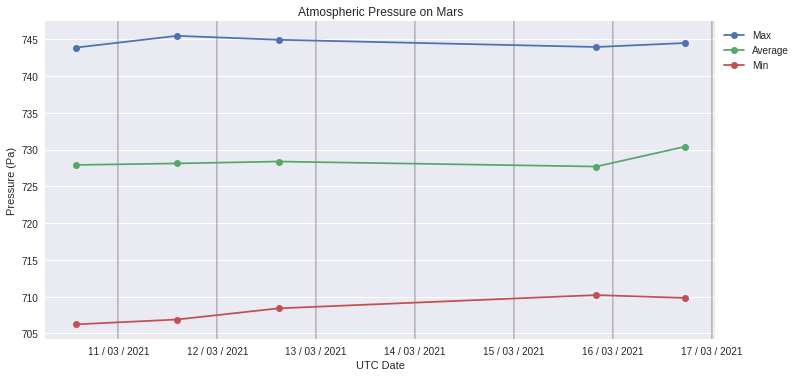

In [22]:
# Get the data to plot
x = full_df.First_UTC
y_av = full_df.av
y_mn = full_df.mn
y_mx = full_df.mx
# Dates for refernce
vlines = pd.date_range(
    start=full_df.First_UTC.to_list()[0].date(),
    end=full_df.Last_UTC.to_list()[-1].date()
)

# Adjust the style and appearance of the plot
plt.style.use("seaborn")
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.tight_layout()

# Adapt the plot to accept datetime objects (and panda's Timestamps)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d / %m / %Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Plot the lines
ax.vlines(vlines,ymin=min(y_mn)-10,ymax=max(y_mx)+10,
          color='black', alpha=0.25)
ax.plot(x, y_mx, '-o', label="Max")
ax.plot(x, y_av, '-o', label="Average")
ax.plot(x, y_mn, '-o', label="Min")

# Plot labels
plt.title("Atmospheric Pressure on Mars")
plt.xlabel("UTC Date")
plt.ylabel("Pressure (Pa)")
plt.legend(bbox_to_anchor=(1,1), loc="best")
plt.show()
plt.close()

**TIME SENSITIVE ANALYSIS**

We can see that there is a gap of over 3 earth days! The average pressure appears to stay around 727.5 Pa, with the exception of the final day (after) 16/03/2021 where it goes up to above 730 Pa despite the Min sample for that day beind lower than the previous day. We can see that the Max for that day also went up, but not as substantially.

The highest pressure sample was recorded between 11/03/2021 and 12/03/2021. Going back to our table we can see that this is 745.4649 Pa. The lowest pressure sample was the very first Sol, aka around 10/03/2021 with the value of 706.2391 Pa. Thats a range of 39.2258 Pa.

As a reference point, the "standard atmosphere" or the average atmospheric pressure at water surface on Earth is 101,325 Pa, almost 140 times larger than the values recorded by the InSight lander!

Now lets go back to the relative Sols and lets take a look at how many samples we got for each.

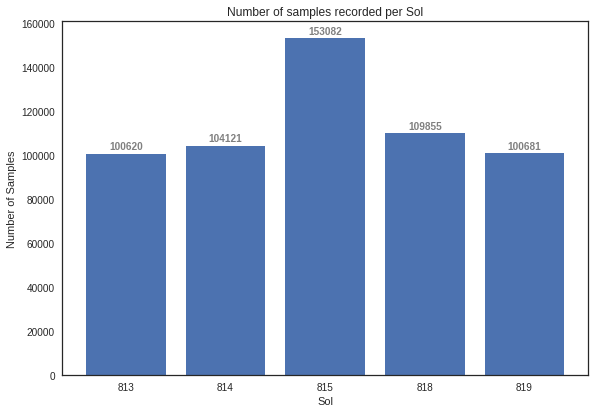

In [23]:
# Get the data to plot
x = full_df.Sol
num_samples = full_df.ct

# Adjust the style and appearance of the plot
plt.style.use("seaborn-white")
fig = plt.figure()
ax = fig.add_subplot(111)
plt.tight_layout()

# Plot the bars
plt.bar(x, num_samples)
# Annotate the bars
for i, patch in enumerate(ax.patches):
    plt.annotate(str(patch.get_height()),
                xy=(x[i], patch.get_height()+2e3),
                fontweight="bold",
                color="grey",
                ha="center")

# Plot labels
plt.title("Number of samples recorded per Sol")
plt.xlabel("Sol")
plt.ylabel("Number of Samples")
plt.show()
plt.close()

**TIME SENSITIVE ANALYSIS**

We can see that we usually get roughly 100 thousand samples per Sol, with the notable exception of Sol 815, where InSight recorded 153082 samples! Looking back at the table and the "Atmospheric Pressure on Mars" plot, we can see that this Sol corresponds to the gap in UTC days in our dataset and this could explain why there is a 50% increase in collected samples that day.

**Curiosity Photos**

Now that we looked at the weather data, lets display the photos for all the available camera sensors on the Curiosity Mars rover for those dates.

#### **Sol 813**


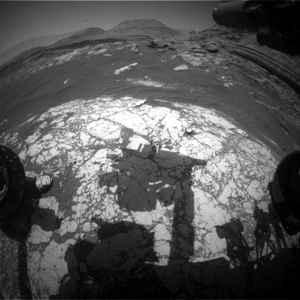
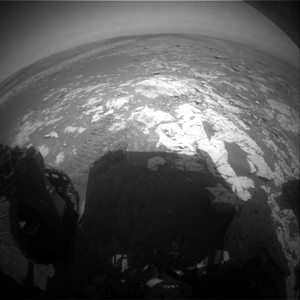
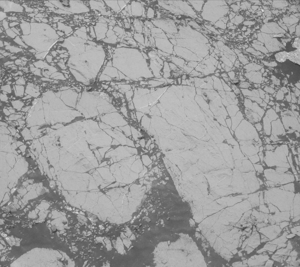
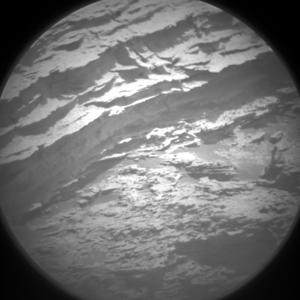
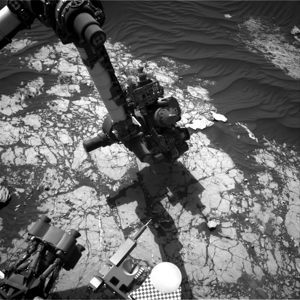


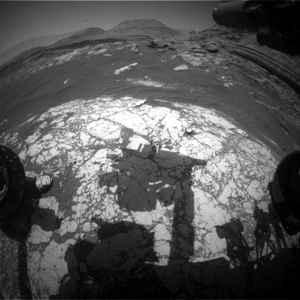
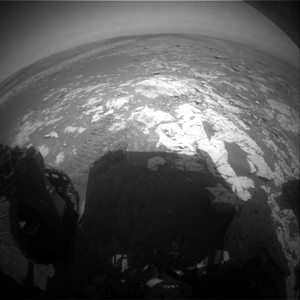
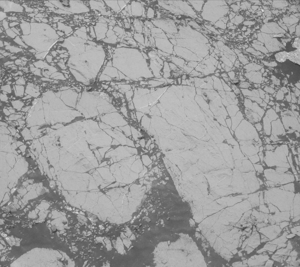
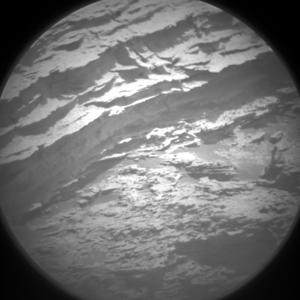
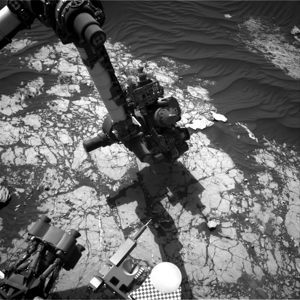

#### **Sol 814**

**None Found**

#### **Sol 815**


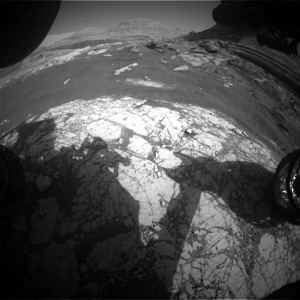
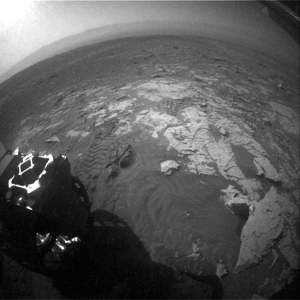
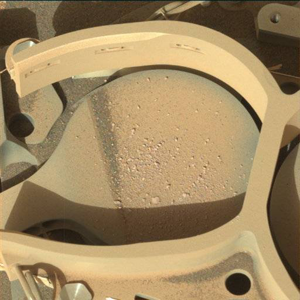
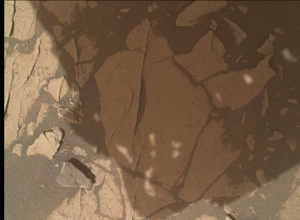
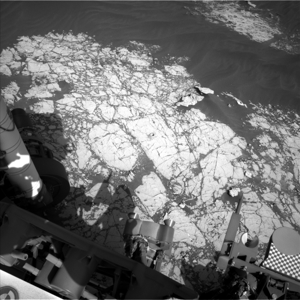


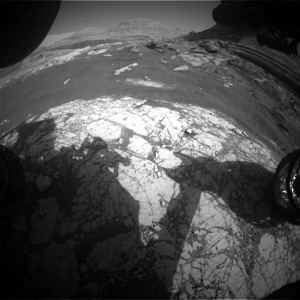
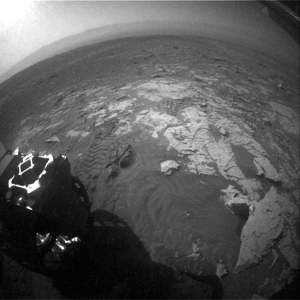
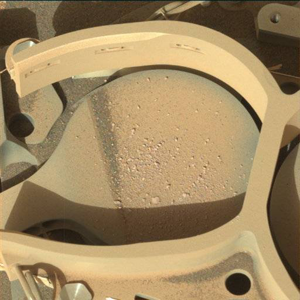
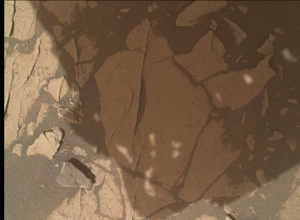
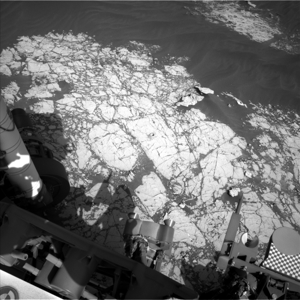

#### **Sol 818**


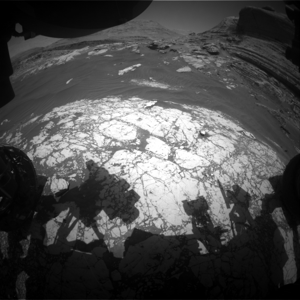
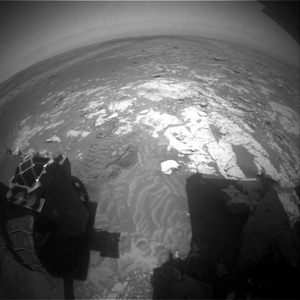
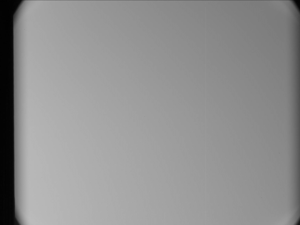
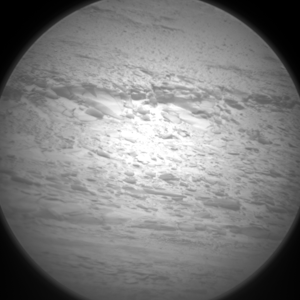
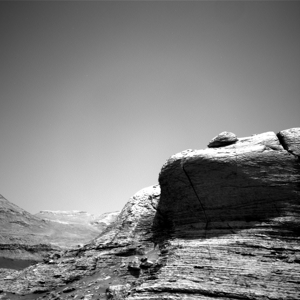


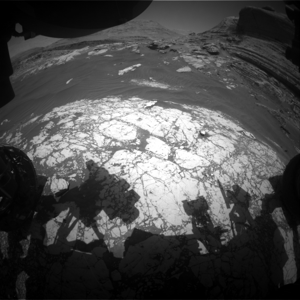
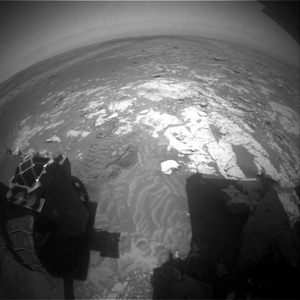
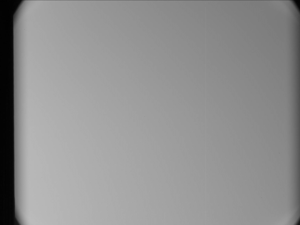
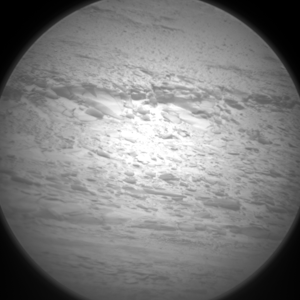
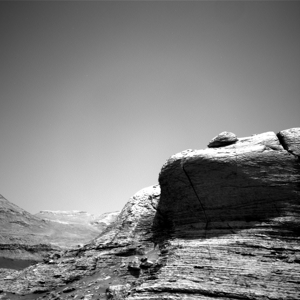

#### **Sol 819**


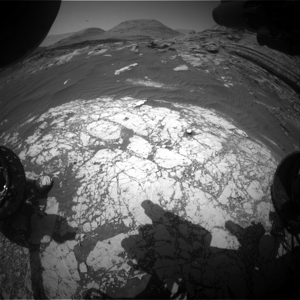
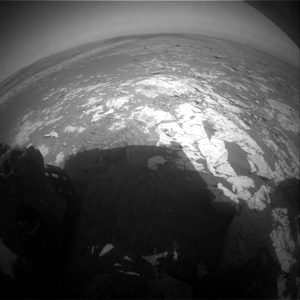
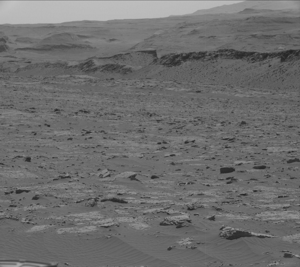
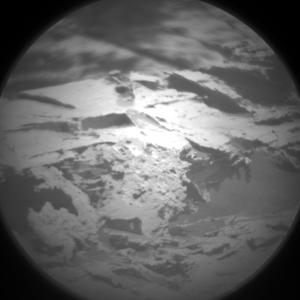
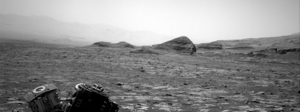


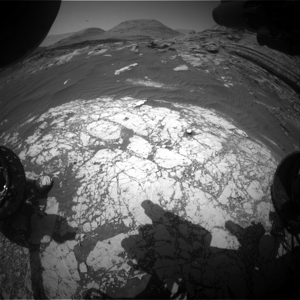
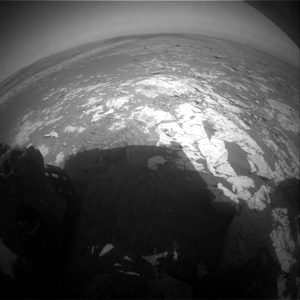
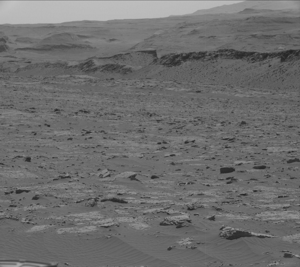
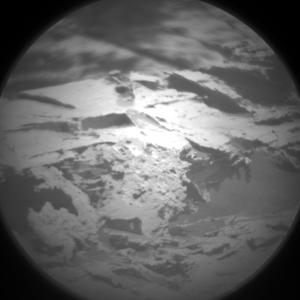
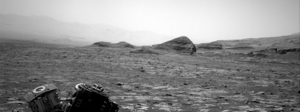

In [24]:
# Display all of the available images for that day
for _,row in full_df.iterrows(): # iterate row-wise over the dataframe
    images_array = [] # photo urls
    labels_array = [] # camera labels
    for i,download_url in enumerate(row[11:]): # select camera rows
        if not download_url == "None Found":
            images_array.append(Image.open(requests.get(
                download_url, stream=True).raw))
            labels_array.append(row.index[i+11])
    display(Markdown(f"#### **Sol {row.Sol}**"))
    if len(images_array) > 0:
        ipyplot.plot_images(images_array, labels_array, img_width=300)
    else: # If theres no images on that day
        display(Markdown("**None Found**"))

**TIME SENSITIVE ANALYSIS**

It appears that there are no photos taken on InSight's 813th Sol! Well, what can the other photos tell us?

Its hard to determine how the weather/pressure affects Mars from these photos. The surface of the planet appears very still in all of the images. A good example of this are the MASt and NAVCAM photos. I can't spot any dust clouds, despite the famed [Martian Dust Storms](https://mars.nasa.gov/news/1854/the-fact-and-fiction-of-martian-dust-storms/)!

Interestingly enough, the rover doesn't appear to have moved very far during these days. We can use the RHAZ (Rear Hazard Avoidance Camera) camera to judge the distance. While slow movement is expected, I am curious why it appears this slow, as the rover usually travels around 50 meters per day (ref: https://mars.nasa.gov/news/1498/curiosity-makes-its-longest-one-day-drive-on-mars/).

PS: You can click on the images to enlarge them.

**Conclusions**

We looked into the Martian atmospheric pressure, captured by the InSight lander for the past 7 Sols, and compared it to some photos captured by the Curiosity rover during the same time period.

We found out that the pressure seems to be fairly static at the moment and is, on average, a lot (140x) lower than Earths.

The data also shows that there can be inconsistencies in both the InSight weather data and Curiosity's image data, with missing data/time periods.

While the Curiosity rover has 7 cameras, it only takes photos using 6 of them, and usually only 5 cameras capture on any given day.

For future work, it would be great to somehow incorporate the more complete weather data captured by the Curiosity rover, and compare it to the photos it captures. It would give a more representative look at the weather at the rover's current geographical location, with greater time precision, due to the matching relative Sols.

If this data was available, having weather data for a longer period of time than roughly a week could allow me to map how the weather changes during the span of a Martian year (687 earth days). It could be interesting to see the differences per season and planet rotation (Sol hour).

As a side note, querying these images and then being able to see photos of Mars in realtime (as much as it is effectively possible) was a very personally satisfying experience.